In [1]:
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
import sys

if "../model" not in sys.path:
    sys.path.insert(0, "../model")

from typing import Any

In [2]:
coco_root = Path("/home/dherrera/data/coco")
training_data_root = Path("/home/dherrera/data/elephants/training_data")

In [ ]:
data_file = coco_root / "annotations/elephants_train2017.json"
coco_json: dict[str, Any] = json.load(data_file.open())
coco_categories = coco_json["categories"]
display(coco_categories)

[{'supercategory': 'animal', 'id': 1, 'name': 'elephant'}]

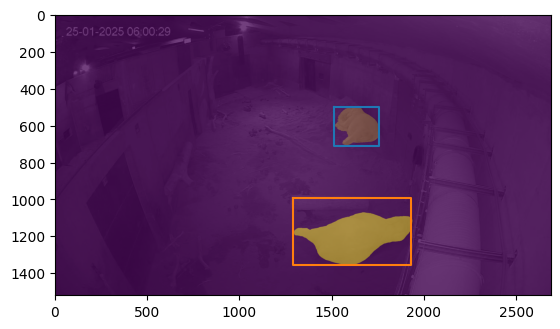

In [ ]:
from segmentation_utils import bbox_from_mask, plot_bbox


image_file = (
    training_data_root
    / "zag_elp_cam_016/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg"
)
segmentation_file = (
    training_data_root
    / "zag_elp_cam_016/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_seg.png"
)

image = cv2.imread(image_file)
segmentation = cv2.imread(segmentation_file, flags=cv2.IMREAD_GRAYSCALE)
ids = list(set(np.unique(segmentation)) - {0})

plt.imshow(image)

for id in ids:
    mask = segmentation == id

    bbox = bbox_from_mask(mask)
    plt.imshow(mask, alpha=0.5)

    plot_bbox(plt.gca(), bbox)

In [4]:
class IDGenerator:
    def __init__(self):
        self.next_id = 1

    def create(self) -> int:
        id = self.next_id
        self.next_id += 1
        return id

Annotation count: 2


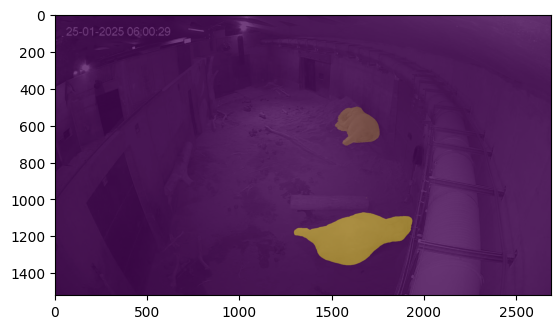

In [23]:
# ELEPHANT_CATEGORY_ID = 22  # Same as in COCO
ELEPHANT_CATEGORY_ID = 1  # COCO with only one category


def create_elephant_annotation():
    return {
        "info": {
            "description": "Zoo Zurich Elephants 2025 Dataset",
            "url": "n/a",
            "version": "0.1",
            "year": 2025,
            "contributor": "Zoo Zurich",
            "date_created": "2025/02/01",
        },
        "licenses": [{"url": "non-public", "id": 1, "name": "Non-public"}],
        "categories": coco_categories,
        "images": [],
        "annotations": [],
    }


def make_image(id: int, name: str, height: int, width: int, date_captured: str):
    return {
        "license": 1,
        "file_name": name,
        "height": height,
        "width": width,
        "date_capture": date_captured,
        "id": id,
    }


import pycocotools.mask as coco_mask


def binary_mask_to_rle_np(binary_mask):
    rle = {"counts": [], "size": list(binary_mask.shape)}

    flattened_mask = binary_mask.ravel(order="F")
    diff_arr = np.diff(flattened_mask)
    nonzero_indices = np.where(diff_arr != 0)[0] + 1
    lengths = np.diff(np.concatenate(([0], nonzero_indices, [len(flattened_mask)])))

    # note that the odd counts are always the numbers of zeros
    if flattened_mask[0] == 1:
        lengths = np.concatenate(([0], lengths))

    rle["counts"] = lengths.tolist()

    return rle


def annotations_from_segmentation(
    id: IDGenerator, segmentation_file: Path, image_id: int
):
    segmentation: np.ndarray = cv2.imread(segmentation_file, flags=cv2.IMREAD_GRAYSCALE)
    instance_ids = list(set(np.unique(segmentation)) - {0})
    annotations = []
    for instance_id in instance_ids:
        mask = segmentation == instance_id
        area = int(np.sum(mask))
        bbox = bbox_from_mask(mask)

        h, w = mask.shape
        mask_rle = binary_mask_to_rle_np(mask)
        # mask = mask.transpose().reshape(h,w)
        # mask = np.asfortranarray(mask)

        # mask_crle = coco_mask.encode(coco_mask.frPyObjects(mask_rle,h,w))
        # mask_crle["counts"]=list(mask_rle["counts"])
        # mask_compressed = coco_mask.frPyObjects(mask_rle, mask_rle.get('size')[0], mask_rle.get('size')[1])
        # mask_compressed =mask_rle

        annotation = {
            "segmentation": [mask_rle],
            "area": area,
            "iscrowd": 0,
            "image_id": image_id,
            "bbox": bbox,
            "category_id": ELEPHANT_CATEGORY_ID,
            "id": id.create(),
        }
        annotations.append(annotation)
    return annotations


annotations = annotations_from_segmentation(IDGenerator(), segmentation_file, 0)
print(f"Annotation count: {len(annotations)}")

from coco_utils import convert_coco_poly_to_mask

image = cv2.imread(image_file)
plt.imshow(image)
for a in annotations:
    segmentations = a["segmentation"]
    mask = convert_coco_poly_to_mask(segmentations, image.shape[0], image.shape[1])[0]
    plt.imshow(mask, alpha=0.5)

In [30]:
from glob import glob

root = Path("/home/dherrera/data/elephants/training_data/")
files = glob("**/*_img.jpg", root_dir=root, recursive=True)
# files = glob("zag_elp_cam_016/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg", root_dir=root, recursive=True)
print(f"Total {len(files)} files")
print(f"For example: {files[0]}")

Total 1715 files
For example: zag_elp_cam_017/ZAG-ELP-CAM-017-26.01.2025-021020-061020_00179348_img.jpg


In [ ]:
from tqdm import tqdm

elephant_annotations = create_elephant_annotation()
gen_image_id = IDGenerator()
gen_annotation_id = IDGenerator()

for file in tqdm(files):
    image_id = gen_image_id.create()
    segmentation_file = root / file.replace("_img.jpg", "_seg.png")

    # Need to read image to get size
    im = cv2.imread(root / file)

    image_json = make_image(
        id=image_id,
        name=file,
        height=im.shape[0],
        width=im.shape[1],
        date_captured="2025-02-01",
    )

    annotations_json = annotations_from_segmentation(
        id=gen_annotation_id, segmentation_file=segmentation_file, image_id=image_id
    )

    elephant_annotations["images"].append(image_json)
    elephant_annotations["annotations"].extend(annotations_json)

annotation_count = len(elephant_annotations["annotations"])
print(f"{annotation_count=}")
with (root / "annotations.json").open("w") as f:
    json.dump(elephant_annotations, f)

100%|██████████| 1715/1715 [01:05<00:00, 26.04it/s]


annotation_count=2803
